# Анализ активности студентов онлайн курса Введение в анализ данных в R

Данный проект реализован в рамках обучения на курсе "Введение в Data Science и машинное обучение".

У нас есть данные по активности студентов онлайн курса "Введение в анализ данных в R" с платформы Stepic (данные реальные).  Необходимо построить модель, которая будет предсказывать, покинет ли пользователь курс или дойдет его до конца. 

# Шаг 1. Предобработка и анализ данных

- Откроем данные,
- Проанализируем поведение пользователей на платформе,
- Подготовим данные со статистикой действий по каждому пользователю.

In [2]:
import pandas as pd
import numpy as np

In [3]:
event_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
event_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


Описание данных: 

events_train.csv - данные о действиях, которые совершают студенты со стэпами

1. step_id - id стэпа
2. user_id - анонимизированный id юзера
3. timestamp - время наступления события в формате unix date
4. action - событие. 

Возможные значения столбца action:

-discovered - пользователь перешел на стэп

-viewed - просмотр шага,

-started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага

-passed - удачное решение практического шага

In [4]:
submissions_data_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data_train

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


Описание данных: 

submissions_data_train - данные о времени и статусах сабмитов к практическим заданиям.

1. step_id - id стэпа
- timestamp - время отправки решения в формате unix date
- submission_status - статус решения
- user_id - анонимизированный id юзера

Для удобства работы с таблицами, чтобы было удобно группировать данные по времени и вообще анализировать время, создадим столбцы с привычным форматом отображения времени. Для этого используем функцию to_datetime.

In [5]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [6]:
submissions_data_train['date'] = pd.to_datetime(submissions_data_train.timestamp, unit='s')
submissions_data_train['day'] = submissions_data_train['date'].dt.date
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Посмотрим, за какой период у нас представлены данные:

In [7]:
event_data.date.min(), event_data.date.max()

(Timestamp('2015-06-15 04:00:48'), Timestamp('2018-05-19 23:33:31'))

В первой таблице данные представлены за почти 3 года: с июня 2015 по май 2018 гг.

In [8]:
submissions_data_train.date.min(), submissions_data_train.date.max()

(Timestamp('2015-06-15 04:02:24'), Timestamp('2018-05-19 23:07:07'))

Во второй таблице период совпадает с первой.

In [9]:
event_data['month'] = event_data['date'].dt.month
event_data.head()

,step_id,timestamp,action,user_id,date,month
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6


In [10]:
event_data['day'] = event_data['date'].dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,month,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6,2015-06-15


Мы добавили в таблицу столбцы с месяцем и днем. Теперь мы можем посмотреть, как менялась со временем популярность курса. 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from matplotlib import rcParams

In [13]:
rcParams['figure.figsize'] = 13, 9

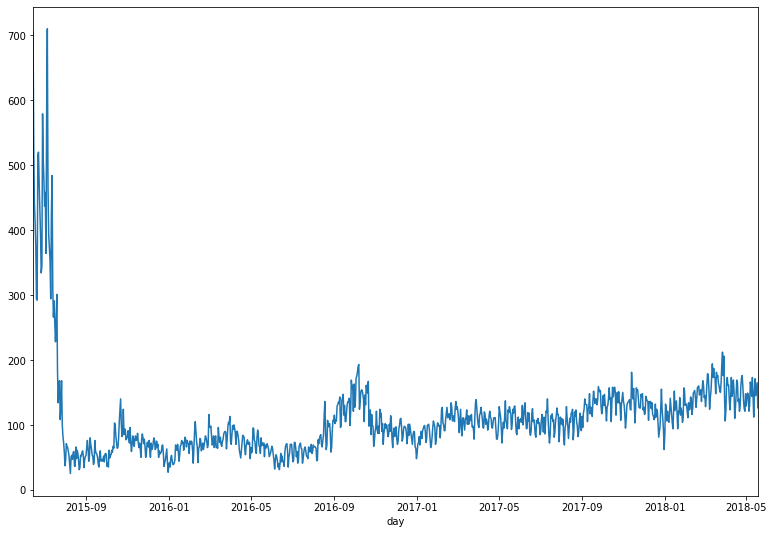

In [14]:
event_data.groupby('day')['user_id'].nunique().plot()

Мы можем видеть, что наибольшее количество пользователей наблюдалось в самом начале запуска курса, затем оно резко снизилось до некоторой отметки, после чего стало медленно расти. Первый скачок связан с тем, что курс только запустился, был в акивной фазе, были дедлайны и пользователи регистрировались, чтобы успеть уложиться в сроки. Затем курс был переведен в более пассивную фазу без дедлайнов, и его популярность неуклонно растет. 

Посмотрим, как распределены пользователи по количеству баллов, которые они набрали. Это поможет отобразить картину, как много пользователей сколько баллов в итоге набирают - и как много доходит курс до конца и получает сертификат.

Чтобы решить задачу, сгруппируем пользователей по id, и для каждого из них посчитаем количество действий со значением "passed", после чего посмотрим на распределение.

In [15]:
event_data.head()

,step_id,timestamp,action,user_id,date,month,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6,2015-06-15


In [16]:
passed = (event_data.query('action=="passed"').groupby
          ('user_id', as_index=False).agg({'action':'count'}).rename(columns={'action':'action_passed'}))
passed.head()

,user_id,action_passed
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


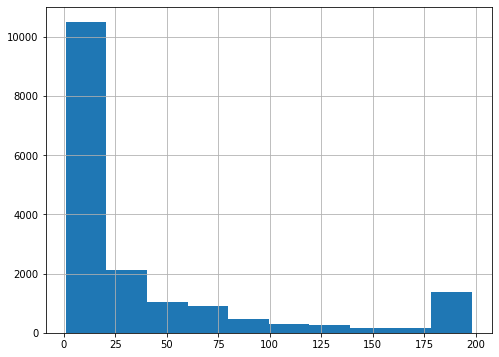

In [17]:
rcParams['figure.figsize'] = 8, 6
passed['action_passed'].hist()

Мы можем видеть, что значительное большинство пользователей выполнило меньше 25 заданий, затем количество набравших определенное количество баллов снижается, и есть некоторый пик тех, кто набрал максимальное количество баллов и сдал все задания (вероятно, это те пользователи, кому было важно сдать все задания, а не просто сдавать задания, которые по силам). 

Однако, в получившемся графике есть одна проблема: в них нет пользователей, которые не сдали ни одного задания, то есть мы не видим нулевых значений, а они есть. 

In [18]:
event_data.head()

,step_id,timestamp,action,user_id,date,month,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6,2015-06-15


In [19]:
passed2 = event_data[['step_id', 'action', 'user_id']].pivot_table(index = 'user_id', columns = 'action', aggfunc = 'count')
passed2

step_id                              
action  discovered passed started_attempt viewed
user_id                                         
1              1.0    NaN             NaN    1.0
2              9.0    9.0             2.0   10.0
3             91.0   87.0            30.0  192.0
5             11.0   11.0             4.0   12.0
7              1.0    1.0             NaN    1.0
...            ...    ...             ...    ...
26790          8.0    8.0             1.0    9.0
26793          1.0    NaN             1.0    1.0
26794         69.0   69.0            34.0  180.0
26797         10.0   10.0             2.0   13.0
26798         12.0   12.0             3.0   12.0

[19234 rows x 4 columns]

In [20]:
passed2 = passed2.fillna(0)
passed2.head()

step_id                              
action  discovered passed started_attempt viewed
user_id                                         
1              1.0    0.0             0.0    1.0
2              9.0    9.0             2.0   10.0
3             91.0   87.0            30.0  192.0
5             11.0   11.0             4.0   12.0
7              1.0    1.0             0.0    1.0

Теперь у нас есть сводная таблица, в которой для каждого user_id посчитано, сколько действий определенного типа он совершил. При этом, если он не прошел ни одного задания, то количество для таких пользователей мы отобразили 0. Посмотрим теперь на график.

In [21]:
passed2.columns = ['discovered', 'passed', 'started_attempt', 'viewed']
passed2.head()

,discovered,passed,started_attempt,viewed
user_id,,,,
1,1.0,0.0,0.0,1.0
2,9.0,9.0,2.0,10.0
3,91.0,87.0,30.0,192.0
5,11.0,11.0,4.0,12.0
7,1.0,1.0,0.0,1.0


In [22]:
passed2['user_id'] = passed2.index
passed2 = passed2.reset_index(drop=True)
passed2

,discovered,passed,started_attempt,viewed,user_id
0,1.0,0.0,0.0,1.0,1
1,9.0,9.0,2.0,10.0,2
2,91.0,87.0,30.0,192.0,3
3,11.0,11.0,4.0,12.0,5
4,1.0,1.0,0.0,1.0,7
...,...,...,...,...,...
19229,8.0,8.0,1.0,9.0,26790
19230,1.0,0.0,1.0,1.0,26793
19231,69.0,69.0,34.0,180.0,26794
19232,10.0,10.0,2.0,13.0,26797


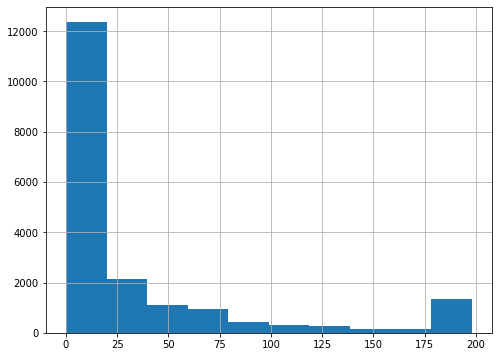

In [23]:
passed2['passed'].hist()

По сравнению с предыдущей гистограммой, столбец по левому край гистограммы теперь вплоную приближен к нулю, и мы видим, что пользователей, которые не выполнили ни одного задания было возле 2х тысяч. 

Теперь проанализируем вторую таблицу: посмотрим для каждого юзера количество правильных и неправильных решений задач.

In [24]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [25]:
submissions_data_train_pivot = (submissions_data_train.pivot_table(index='user_id', columns='submission_status',
                                                                   values='date', aggfunc='count'))
submissions_data_train_pivot.head()

submission_status,correct,wrong
user_id,,
2,2.0,NaN
3,29.0,23.0
5,2.0,2.0
8,9.0,21.0
14,NaN,1.0


In [26]:
submissions_data_train_pivot = submissions_data_train_pivot.fillna(0)#заполним пропуски

In [27]:
submissions_data_train_pivot.head()

submission_status,correct,wrong
user_id,,
2,2.0,0.0
3,29.0,23.0
5,2.0,2.0
8,9.0,21.0
14,0.0,1.0


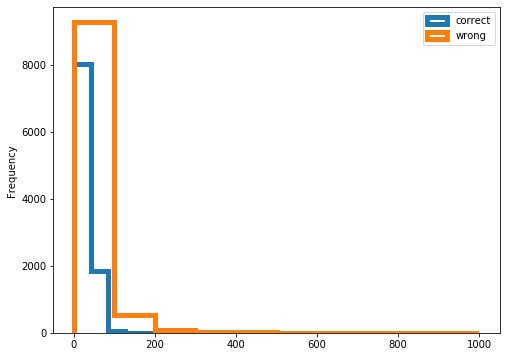

In [28]:
ax = submissions_data_train_pivot.correct.plot(kind='hist', histtype='step', label='correct', linewidth=5, legend=True)
submissions_data_train_pivot.wrong.plot(kind='hist', histtype='step', ax=ax, label='wrong', linewidth=5, legend=True)

Как и было ожидаемо, ошибочных решений больше, чем верных. При этом 0 ошибок и 0 верных решений могут наблюдаться у тех (их много), кто не стал в итоге проходить курс или забросил его.

Посмотрим для каждого юзера соотношение его ошибочных и верных решений:

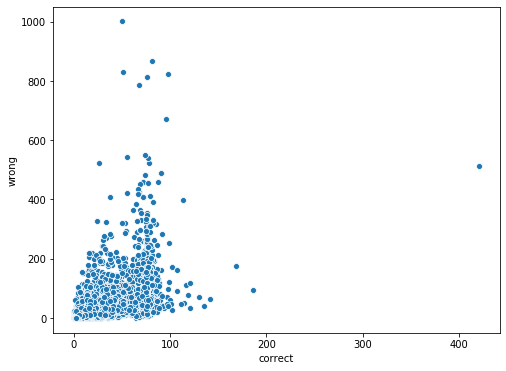

In [29]:
sns.scatterplot(data = submissions_data_train_pivot, x='correct', y='wrong')

Мы видим, что для каждого пользователя определено его положение относительно верных и неверных решений. Наибольшее количество неверных решений (1000) набрал пользователь, решивший верно всего 50 заданий. Наибольшее количество верных решений (400) решил одинокий юзер, при этом у него 600 неверных решений (то есть в среднем его решения оказывались верными со второй-третьей попытки). Большая часть пользователей решила максимум 100 заданий, при этом на каждый верный ответ наиболее часто приходилось 2-4 неверных. 

In [30]:
submissions_data_train_pivot.correct.corr(submissions_data_train_pivot['wrong'])

0.6166124775910634

Мы видим некоторую (среднюю) линейную корреляцию между количеством решенных верно заданий и количеством неверных ответов, впрочем такая корреляция вполне объяснима. 

Для того, чтобы решить задачу, необходимо понять, каких пользователей считать забросившими обучение. Для этого нужно определить срок отсутствия для не получивших сертификаты пользователей, достаточный для того, чтобы считать, что он больше не вернется на курс. 

Чтобы определиться, какой срок считать корректным, нам нужно посмотреть на распределение количества дней перерыва для юзеров. 

1. Отберем из таблицы нужные колонки и удалим дубликаты. Нам нужно, чтобы для каждого пользователя был зафиксирован день его активности, и чтобы эти пары значений не повторялись, т.к. нам достаточно только одного действия пользователя в какой-то из дней, чтобы не считать этот день перерывом. 

Также нам понадобится колонка timestamp для подсчета времени дней перерыва. 

In [31]:
event_data.head()

,step_id,timestamp,action,user_id,date,month,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6,2015-06-15


In [32]:
gap_data = event_data[['user_id', 'timestamp', 'day']].drop_duplicates(subset=['user_id', 'day'])
gap_data.head()

,user_id,timestamp,day
0,17632,1434340848,2015-06-15
36,12494,1434341931,2015-06-15
59,442,1434342029,2015-06-15
62,22254,1434342042,2015-06-15
94,6646,1434342230,2015-06-15


Сгруппируем пользователей по id, и применим функцию list к столбцу timestamp.

In [33]:
gap_data_grouped = gap_data.groupby('user_id')['timestamp'].apply(list)
gap_data_grouped.head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

Посчитаем перерывы между активностями для пользователей методом np.diff, который вместо списка записей timestamp вернет список перерывов между ними (в секундах).

In [34]:
gap_data_diff = gap_data_grouped.apply(np.diff)
gap_data_diff

user_id
1                                                       []
2                                                [4843602]
3         [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                               [33702812]
7                                                       []
                               ...                        
26790                           [238225, 893964, 64879648]
26793                                                   []
26794    [86128, 136759, 94899, 1422583, 14347289, 5050...
26797                                            [1567990]
26798                                                   []
Name: timestamp, Length: 19234, dtype: object

Теперь разобьем эти списки на отдельные элементы.

In [35]:
gaps_values = gap_data_diff.values
gaps_values

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
          98252,    57019]),
       array([1567990]), array([], dtype=int32)], dtype=object)

Объеденим значения в единый список из получившихся блоков.

In [36]:
splited = np.concatenate(gaps_values)
splited

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990])

In [37]:
gaps = pd.Series(splited)
gaps.head()

0    4843602
1    6899249
2     182484
3      93710
4    2768870
dtype: int32

Мы получили список значений перерывов между днями активности для пользователей. Переведем значения в дни.

In [38]:
gaps_days = (gaps / 60 /60 /24).astype('int')
gaps_days

0         56
1         79
2          2
3          1
4         32
        ... 
97867    166
97868      5
97869      1
97870      0
97871     18
Length: 97872, dtype: int32

Теперь построим гистограмму и посмотрим на распределение.

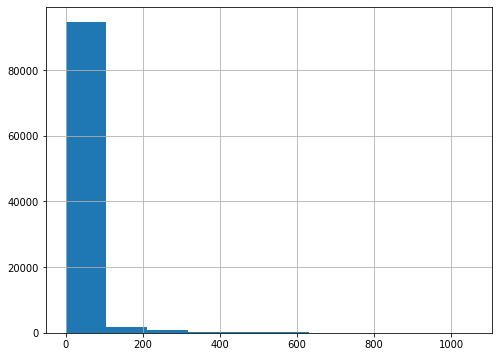

In [39]:
gaps_days.hist()

Из-за выбросовых значений почти все данные оказались в одном столбце. 

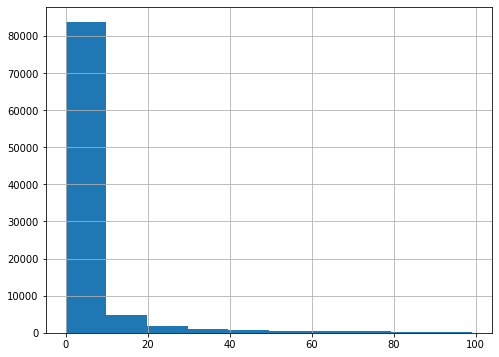

In [40]:
gaps_days[gaps_days<100].hist()

По гистограмме видим, что для большинства пользователей максимальный перерыв между активными днями - 30 дней. Очень малое их количество заходило на курс еще раз, если проходило более, чем 30 дней перерыва. Убедимся в этом, посмотрев на значение 95%-нтного квантиля:

In [41]:
gaps_days[gaps_days<100].quantile(.95)

25.0

Мы ограничили данные 100 днями, т.к. по графику это очень отклоняющиеся значения. Если мы возьмем все данные и чуть более низкий квантиль от них, 90%, мы получим еще более низкие цифры:

In [42]:
gaps_days.quantile(.90)

18.0

Теперь нам нужно разметить данные. Для начала создадим новый столбец, в котором будет отображаться True, если пользователь не проявлял активности больше 30 дней от текущего (на момент выгрузки данных) момента.

In [43]:
event_data.head()

,step_id,timestamp,action,user_id,date,month,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6,2015-06-15


In [44]:
now_time = event_data.timestamp.max()
now_time

1526772811

In [45]:
mean_gap = 30*24*60*60 #переведем 30 дней в секунды
mean_gap

2592000

In [46]:
users_gaps_features = event_data.groupby('user_id', as_index=False)['timestamp'].max().rename(columns={'timestamp':'max_timestamp'})
users_gaps_features

,user_id,max_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [47]:
users_gaps_features['is_gape_more_30'] = (now_time - users_gaps_features.max_timestamp) >= mean_gap
users_gaps_features

,user_id,max_timestamp,is_gape_more_30
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


Теперь необходимо эту разметку подкорректировать таким образом, чтобы отсеять получивших сертификаты пользователей. Соединим полученную таблицу с данными о количестве правильных и ошибочных ответов для пользователей.

In [48]:
submissions_data_train_pivot.columns

Index(['correct', 'wrong'], dtype='object', name='submission_status')

In [49]:
submissions_data_train_pivot.columns = ['correct', 'wrong']

In [50]:
submissions_data_train_pivot['user_id'] = submissions_data_train_pivot.index
submissions_data_train_pivot = submissions_data_train_pivot.reset_index(drop=True)

In [51]:
users_gaps_features_merged = users_gaps_features.merge(submissions_data_train_pivot, on='user_id', how='left')
users_gaps_features_merged

,user_id,max_timestamp,is_gape_more_30,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,NaN,NaN
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [52]:
users_data = users_gaps_features_merged.merge(passed2, how='left')
users_data

,user_id,max_timestamp,is_gape_more_30,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1.0,0.0,0.0,1.0
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0
4,7,1521634660,True,NaN,NaN,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8.0,8.0,1.0,9.0
19230,26793,1510225034,True,NaN,NaN,1.0,0.0,1.0,1.0
19231,26794,1512035039,True,33.0,9.0,69.0,69.0,34.0,180.0
19232,26797,1509995096,True,2.0,0.0,10.0,10.0,2.0,13.0


Теперь у нас есть сводная статистическая таблица по каждому пользователю: его последняя активность, был ли перерыв больше 30 дней с момента выгрузки данных, количество корректных и ошибочных ответов, количество открытых и пройденных шагов и количество просмотром. 

Теперь добавим в таблицу еще один элемент - количество активных дней. 

In [53]:
days = event_data.groupby('user_id', as_index=False)['day'].count()
days

,user_id,day
0,1,2
1,2,30
2,3,400
3,5,38
4,7,3
...,...,...
19229,26790,26
19230,26793,3
19231,26794,352
19232,26797,35


In [54]:
users_data = users_data.merge(days, how='left')
users_data

,user_id,max_timestamp,is_gape_more_30,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1.0,0.0,0.0,1.0,2
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,30
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,400
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,38
4,7,1521634660,True,NaN,NaN,1.0,1.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8.0,8.0,1.0,9.0,26
19230,26793,1510225034,True,NaN,NaN,1.0,0.0,1.0,1.0,3
19231,26794,1512035039,True,33.0,9.0,69.0,69.0,34.0,180.0,352
19232,26797,1509995096,True,2.0,0.0,10.0,10.0,2.0,13.0,35


Убедимся, что мы не потеряли юзеров при всех этих преобразованиях.

In [55]:
users_data.user_id.nunique()

19234

In [56]:
event_data.user_id.nunique()

19234

Количество пользователей совпадает, никого не потеряли. Теперь добавим последний признак - закончил ли пользователь курс. 
Добавим столбец, где будет указано True, если количество пройденных степов больше 170 (условие для получения сертификата).

In [57]:
users_data = users_data.fillna(0)

In [58]:
users_data['passed_course'] = users_data.passed >= 170
users_data

,user_id,max_timestamp,is_gape_more_30,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0,2,False
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,30,False
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,400,False
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,38,False
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0,3,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8.0,8.0,1.0,9.0,26,False
19230,26793,1510225034,True,0.0,0.0,1.0,0.0,1.0,1.0,3,False
19231,26794,1512035039,True,33.0,9.0,69.0,69.0,34.0,180.0,352,False
19232,26797,1509995096,True,2.0,0.0,10.0,10.0,2.0,13.0,35,False


Посмотрим, как много юзеров справилось с курсом:

In [59]:
users_data.passed_course.value_counts()

False    17801
True      1433
Name: passed_course, dtype: int64

Успешно завершили курс около 8% пользователей. 

## Вывод

В данном разделе мы ознакомились с данными, провели их предобработку, проанализировали поведение пользователей и создали сводную таблицу по каждому пользователю с указанием важной статистической информации по нему. 

Мы выяснили, что:
- Успешно завершили курс около 8% пользователей.
- Для большинства пользователей максимальный перерыв между активными днями - 30 дней. Очень малое их количество заходило на курс еще раз, если проходило более, чем 30 дней перерыва.
- Большая часть пользователей решила максимум 100 заданий, при этом на каждый верный ответ наиболее часто приходилось 2-4 неверных.

# Шаг 2. Построение моделей

In [60]:
from sklearn import tree

Нам предстоит решить, за какой минимальный срок от начала прохождения курса мы сможем достаточно точно классифицировать, покинет ли пользователь курс.

То есть план действий будет такой: 
- Определить периоды: по первому дню активности, по 3м дням, по неделе, по двум неделям, по месяцу. 
- Предположительно, чем более долгий срок мы указываем - тем больше шансов правильно классифицировать, однако нас может не устроить слишком долгий срок понимания, потому что можно не успеть отреагировать и удержать пользователя. Поэтому, нам нужно посмотреть на различие результатов работы моделей и подобрать оптимальный срок. 

Для начала нам необходимо убрать из глобальной таблицы users_data тех пользователей, для которых is_gape_more_30 = False: это пользователи, про которых мы считаем, что нам неизвестно еще, покинут они курс или нет, поскольку, предположительно, находятся еще в стадии прохождения. При этом нам нужно оставить тех из них, кто уже получил сертификат. 

In [61]:
actual_users = users_data.query('is_gape_more_30 == True or (is_gape_more_30 == False and passed_course == True)')

In [62]:
actual_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17986 entries, 0 to 19233
Data columns (total 11 columns):
user_id            17986 non-null int64
max_timestamp      17986 non-null int64
is_gape_more_30    17986 non-null bool
correct            17986 non-null float64
wrong              17986 non-null float64
discovered         17986 non-null float64
passed             17986 non-null float64
started_attempt    17986 non-null float64
viewed             17986 non-null float64
day                17986 non-null int64
passed_course      17986 non-null bool
dtypes: bool(2), float64(6), int64(3)
memory usage: 1.4 MB


Добавим в таблицу actual_users еще столбец timestamp_min.

In [63]:
event_data.head()

,step_id,timestamp,action,user_id,date,month,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,6,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,6,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,6,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,6,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,6,2015-06-15


In [64]:
event_data_group = event_data.groupby('user_id', as_index=False)['timestamp'].min()
event_data_group = event_data_group.rename(columns={'timestamp':'min_timestamp'})

In [65]:
event_data = event_data.merge(event_data_group, on='user_id', how='inner')

In [66]:
actual_users = actual_users.merge(event_data_group[['user_id', 'min_timestamp']], on = 'user_id', how = 'inner')

In [67]:
actual_users

,user_id,max_timestamp,is_gape_more_30,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1.0,0.0,0.0,1.0,2,False,1472827464
1,2,1519226966,True,2.0,0.0,9.0,9.0,2.0,10.0,30,False,1514383364
2,3,1444581588,True,29.0,23.0,91.0,87.0,30.0,192.0,400,False,1434358476
3,5,1499859939,True,2.0,2.0,11.0,11.0,4.0,12.0,38,False,1466156809
4,7,1521634660,True,0.0,0.0,1.0,1.0,0.0,1.0,3,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
17981,26790,1517495987,True,1.0,0.0,8.0,8.0,1.0,9.0,26,False,1451484016
17982,26793,1510225034,True,0.0,0.0,1.0,0.0,1.0,1.0,3,False,1510225031
17983,26794,1512035039,True,33.0,9.0,69.0,69.0,34.0,180.0,352,False,1495287049
17984,26797,1509995096,True,2.0,0.0,10.0,10.0,2.0,13.0,35,False,1508425316


In [230]:
submissions_data_train = submissions_data_train.merge(event_data_group, on='user_id', how='inner')

In [68]:
submissions = submissions_data_train[['submission_status', 
                        'user_id', 'step_id']].pivot_table(index='user_id',
                                                          columns = 'submission_status',
                                                          values = 'step_id', aggfunc='count').reset_index().fillna(0)

In [69]:
submissions

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0
...,...,...,...
9935,26787,3.0,0.0
9936,26790,1.0,0.0
9937,26794,33.0,9.0
9938,26797,2.0,0.0


In [70]:
users_data = users_data.merge(event_data_group, on='user_id', how='left').rename(columns={'timestamp':'min_timestamp'})

Теперь напишем функцию, которая будет на вход получать количество дней, а на выходе формировать таблицу про прототипу actual_users, только с данными за указанное количество дней активности, а не за весь период.

In [245]:
def query_days(d):
    days = event_data.copy()
    days['period'] = days['min_timestamp'] + d*24*60*60
    days_query = days.query('min_timestamp <= timestamp <= period')
    days_pivot = days_query.pivot_table(index = 'user_id', 
                                       columns = 'action', 
                                       values = 'step_id', 
                                       aggfunc='count').reset_index().fillna(0)
    merged = days_pivot.merge(actual_users[['max_timestamp', 'passed_course', 'min_timestamp', 'user_id']], on = 'user_id', how='left')
    submissions_d = submissions_data_train.copy()
    submissions_d['periodS'] = submissions_d['min_timestamp'] + d*24*60*60
    submissions_d = submissions_d.query('min_timestamp <= timestamp <= periodS')
    submissions_pivot = submissions_d[['submission_status', 
                        'user_id', 'step_id']].pivot_table(index='user_id',
                                                          columns = 'submission_status',
                                                          values = 'step_id', aggfunc='count').reset_index().fillna(0)
    merged = merged.merge(submissions_pivot, on = 'user_id', how = 'left')
    merged.passed_course = merged.passed_course.fillna(0).astype('int')
    return merged.fillna(0).set_index('user_id').reset_index().drop(['min_timestamp', 'max_timestamp', 'user_id'], axis=1)

Теперь мы можем формировать actual_users за любой период. Мы оставили в ней только те признаки, который понадобятся для обучения моделей. 


Проверим функцию. Например, получим таблицу actual_users для 3х дней.

In [361]:
three = query_days(3)

In [362]:
three

,discovered,passed,started_attempt,viewed,passed_course,correct,wrong
0,1.0,0.0,0.0,1.0,0,0.0,0.0
1,9.0,9.0,2.0,9.0,0,2.0,0.0
2,15.0,15.0,4.0,20.0,0,4.0,4.0
3,1.0,1.0,0.0,1.0,0,0.0,0.0
4,1.0,1.0,0.0,1.0,0,0.0,0.0
...,...,...,...,...,...,...,...
19229,6.0,6.0,1.0,6.0,0,1.0,0.0
19230,1.0,0.0,1.0,1.0,0,0.0,0.0
19231,61.0,61.0,32.0,134.0,0,31.0,9.0
19232,10.0,10.0,2.0,10.0,0,2.0,0.0


Теперь получим для 1 дня и для 14 дней, после чего сравним, насколько отличаются данные друг от друга.

In [248]:
one = query_days(1)
fourteen = query_days(14)

In [249]:
compare = one['wrong']==fifty['wrong']
compare.value_counts()

True     13382
False     5852
Name: wrong, dtype: int64

In [250]:
compare = one['discovered']==fourteen['discovered']
compare.value_counts()

True     13435
False     5799
Name: discovered, dtype: int64

Всего лишь для 5799 юзеров из 19234 отличается результат между первым и 14-м днем, во всяком случае для проверенных столбцов. Проверим эту информацию для остальных.

In [263]:
compare = one.iloc[:, 0]==fourteen.iloc[:, 0]
for i in range(1,7):
    compare = compare & (one.iloc[:, i]==fourteen.iloc[:, i])
    
    

In [264]:
compare.value_counts()

True     12020
False     7214
dtype: int64

Всего лишь для 7214 юзеров из 19234 хоть как-то отличаются по своим действиям между 1м и 14м днем активности. Это говорит о том, что большинство юзеров, которые так и не прошли курс - причем, подавляющее большинство, - проявились уже в первый день. Так же это означает, что понять, будет ли пользователь дальше проходить курс или нет, можно и по первому его дню активности, в большинстве случаев. 

Можем предположить, что если брать разницу между вторым и 14м днем, то она будет еще меньше: те, кто записался на курс, попробовал его пройти только на следующий день и там же прекратил свое намерение.

In [265]:
two = query_days(2)

In [266]:
compare = two.iloc[:, 0]==fourteen.iloc[:, 0]
for i in range(1,7):
    compare = compare & (two.iloc[:, i]==fourteen.iloc[:, i])
compare.value_counts()

True     12684
False     6550
dtype: int64

Действительно, это количество сократилось еще почти на тысячу. В связи этим, попробуем обучить модель на данных за 2 дня активности. 

In [354]:
class Research():
    def Rfit(self, data):
        self.data = data
    def tvt_split(self):
        '''функцию, которая будет разбивать таблицу на 4 части: 
        обучающую, валидационную и тестовую и обучающе-валидационную (для переобучения модели 
        перед финальным тестированием).'''
        from sklearn.model_selection import train_test_split
        self.train_valid, self.test = train_test_split(self.data, 
                                                        test_size=0.2)
        self.train, self.valid = train_test_split(self.train_valid, test_size=0.2)
        return self.train_valid, self.train, self.valid, self.test
    def make_f(self):
        '''Разбивает признаки на обучающие и целевой'''
        self.tr_vX, self.tr_vY = self.train_valid.drop('passed_course',
                                                       axis=1), self.train_valid.passed_course
        self.trX, self.trY = self.train.drop('passed_course',
                                                       axis=1), self.train.passed_course
        self.vX, self.vY = self.valid.drop('passed_course',
                                                       axis=1), self.valid.passed_course
        self.tX, self.tY = self.test.drop('passed_course',
                                                       axis=1), self.test.passed_course
        return self.tr_vX, self.tr_vY, self.trX, self.trY, self.vX, self.vY, self.tX, self.tY
    def best_forest(self, dict_f):
        '''Принимает на вход словарь параметров и возвращает лучший 
        результат для леса'''
        from sklearn.model_selection import GridSearchCV
        from sklearn.ensemble import RandomForestClassifier     
        from sklearn.metrics import roc_auc_score
        params = dict_f
        model = RandomForestClassifier(random_state = 0)
        grid = GridSearchCV(model, params, cv=3)
        grid.fit(self.trX, self.trY)
        self.forest = grid.best_estimator_
        self.forest.fit(self.trX, self.trY)
        self.proba_forest = self.forest.predict_proba(self.vX)
        self.proba_forest1 = self.proba_forest[:,1]
        self.auc_forest = roc_auc_score(self.vY, self.proba_forest1)
        return self.auc_forest
    def best_cat(self, dict_c):
        '''Принимает на вход словарь параметров и возвращает лучший 
        результат для cat boosting'''
        from catboost import CatBoostClassifier
        from sklearn.metrics import roc_auc_score
        params = dict_c
        self.cat = CatBoostClassifier(iterations = 300, random_state = 0)
        self.cat.grid_search(params, X = self.trX, y = self.trY,
                            verbose = False, plot = False, search_by_train_test_split = True,
                            cv = 3, refit=True, shuffle=True)
        
        self.cat.fit(self.trX, self.trY)
        self.cat_proba = self.cat.predict_proba(self.vX)
        self.cat_proba1 = self.cat_proba[:,1]
        self.auc_cat = roc_auc_score(self.vY, self.cat_proba1)
        
        return self.auc_cat
    def best_lgbm(self, dict_l):
        from lightgbm import LGBMClassifier
        from sklearn.model_selection import GridSearchCV
        from sklearn.metrics import roc_auc_score
        params1 = dict_l
        model = LGBMClassifier(random_state = 0, n_estimators=300)
        grid = GridSearchCV(model, params1, cv=3)
        grid.fit(self.trX, self.trY)
        self.light = grid.best_estimator_
        self.light.fit(self.trX, self.trY)        
        self.light_proba = self.light.predict_proba(self.vX)
        self.light_proba1 = self.light_proba[:,1]
        self.auc_light = roc_auc_score(self.vY, self.light_proba1)
        
        return self.auc_light
    def auc_roc_func(self, kind):
        '''Переобучает модель на более полных данных и выводит график
        roc кривой для тестовой выборки'''
        from sklearn.metrics import roc_auc_score
        from sklearn.metrics import roc_curve
        import matplotlib.pyplot as plt
        if kind == 'forest_m':
            self.forest.fit(self.tr_vX, self.tr_vY)
            self.proba_forest2 = self.forest.predict_proba(self.tX)
            proba = self.proba_forest2
        elif kind == 'cat_m':
            self.cat.fit(self.tr_vX, self.tr_vY)
            self.cat_proba2 = self.cat.predict_proba(self.tX)
            proba = self.cat_proba2
        elif kind == 'lgbm_m':
            self.light.fit(self.tr_vX, self.tr_vY)
            self.light_proba2 = self.light.predict_proba(self.tX)
            proba = self.light_proba2
        else:
            print('kind может принимать только значения forest_m, cat_m или lgbm_m')
        proba1 = proba[:, 1]
        self.auc = roc_auc_score(self.tY, proba1)
        fpr, tpr, thresholds = roc_curve(self.tY, proba1)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1], linestyle='--')
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.0])
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve')
        plt.show()
        
        return print('roc_auc_score^ ', self.auc)


Теперь протестируем 3 вида моделей с различными гипер-параметрвми.

In [355]:
r =  Research()

r.Rfit(two)

train_valid, train, valid, test = r.tvt_split()

tr_vX, tr_vY, trX, trY, vX, vY, tX, tY = r.make_f()

In [359]:
d = {'max_depth':range(3,13), 'n_estimators':range(20, 130, 5)}

r.best_forest(d)

0.8154162707232219

In [345]:
c = {'max_depth':range(4,8), 'learning_rate':[0.2,0.3,0.4]}
r.best_cat(c)


bestTest = 0.2106747598
bestIteration = 77


bestTest = 0.2094585038
bestIteration = 47


bestTest = 0.2114571727
bestIteration = 31


bestTest = 0.2104329102
bestIteration = 95


bestTest = 0.2116972509
bestIteration = 49


bestTest = 0.2125841381
bestIteration = 9


bestTest = 0.2123530989
bestIteration = 22


bestTest = 0.2114788694
bestIteration = 12


bestTest = 0.2125020793
bestIteration = 12


bestTest = 0.2111456752
bestIteration = 28


bestTest = 0.2121924579
bestIteration = 20


bestTest = 0.2127837441
bestIteration = 15

0:	learn: 0.4072849	total: 4.36ms	remaining: 1.3s
1:	learn: 0.3040715	total: 8.93ms	remaining: 1.33s
2:	learn: 0.2500185	total: 13.1ms	remaining: 1.29s
3:	learn: 0.2342032	total: 17.5ms	remaining: 1.3s
4:	learn: 0.2224639	total: 21.8ms	remaining: 1.29s
5:	learn: 0.2194442	total: 26.1ms	remaining: 1.28s
6:	learn: 0.2159362	total: 30.5ms	remaining: 1.28s
7:	learn: 0.2134793	total: 35ms	remaining: 1.28s
8:	learn: 0.2116761	total: 39.3ms	remaining: 1.27s
9:	lea

0.8011709944059447

In [356]:
l = {'max_depth':range(4,10), 'learning_rate':[0.2,0.3,0.4]}
r.best_lgbm(l)

0.800771206207346

Итак, при текущих параметрах наилучший результат показала модель случайного леса. Посмотрим на рок-кривую этой модели, а также на резултат метрики для тестовой выборки.

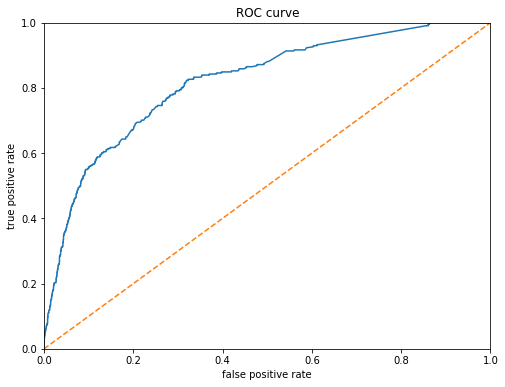

roc_auc_score^  0.8190540840377705


In [360]:
r.auc_roc_func('forest_m')

Теперь посмотрим, насколько нам удастся улучшить результат, если мы будем оценивать не 2 дня активности, а 3. 

In [363]:
r =  Research()

r.Rfit(three)

train_valid, train, valid, test = r.tvt_split()

tr_vX, tr_vY, trX, trY, vX, vY, tX, tY = r.make_f()

In [364]:
r.best_forest(d)

0.8294048091243142

Оценка немного выросла, что, впрочем, понятно: за три дня еще больше информации, чем за два. 

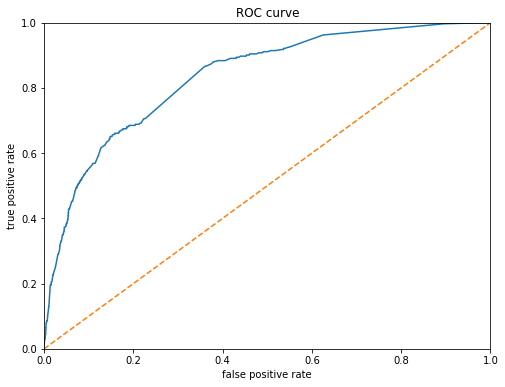

roc_auc_score^  0.8338236710787431


In [365]:
r.auc_roc_func('forest_m')

На тестовой выборке результат снова получился выше.

## Вывод

В этом проекте мы проанализировали поведение студентов онлайн-курса с платформы Степик. 

По итогам мы можем сказать следующее:

- Большинство студентов (возле 2/3) не продолжает проходить курс спустя 1-2 дня: вероятно, это те, кто не нашли в этом курсе того, что искали, и сразу это поняли. Либо те, кому курс показался слишком сложным. 
- Для того, чтобы понять, пройдет ли человек курс или нет, в подавляющем большинстве случаев должно хватить лишь 3х дней наблюдения.

Также мы выяснили, что:

- Успешно завершили курс около 8% пользователей.
- Для большинства пользователей максимальный перерыв между активными днями - 30 дней. Очень малое их количество заходило на курс еще раз, если проходило более, чем 30 дней перерыва.
- Большая часть пользователей решила максимум 100 заданий, при этом на каждый верный ответ наиболее часто приходилось 2-4 неверных.

По итогам анализа мы протестировали три модели с различными гиперпараметрами и отобрали лучшую из них. Наиболее высокое значение метрики, которой удалось добиться на тестовой выборке - 0.8338.

